# Table of Contents
 <p>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \newcommand{\bnaive}{\widehat{\beta}}
    \newcommand{\bbayes}{\widetilde{\beta}}
    \newcommand{\bboot}{\beta^{*}}
    \newcommand{\bdouble}{\beta^{**}}
    \newcommand{\bbootnv}{\hat{\beta}^*}
    \newcommand{\bbootby}{\widetilde{\beta}^*}
    \newcommand{\bcorrect}{\beta^{\checkmark}}
    \newcommand{\bbayescorrect}{\widetilde{\beta}^{\checkmark}}
    \newcommand{\ybar}{\bar{Y}}
    \newcommand{\ypred}{\widetilde{y}}
    \newcommand{\ybarpred}{\widetilde{\bar{Y}}}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \newcommand{\thresh}{\ybar{}_0}
    \newcommand{\muo}{\mu_{0}}
    \newcommand{\sigo}{\sigma_{0}}
    \newcommand{\hmt}{\bar{Y_t}}
    \newcommand{\hst}{s_t^2}
    \newcommand{\hmc}{\bar{Y_c}}
    \newcommand{\hsc}{s_c^2}
    \newcommand{\mt}{\mu_t}
    \newcommand{\sigt}{\sigma_t}
    \newcommand{\vt}{\sigma_t^2}
    \newcommand{\mc}{\mu_c}
    \newcommand{\vc}{\sigma_c^2}
    \newcommand{\sigc}{\sigma_c}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
$$

This notebook is a quick demonstration that under our current model, information about the treatment effect parameter $\tau$ can be obtained from far away from the discontinuity. This is incompatible with the regression discontinuity idea that only information near the discontinuity should be used. As such, I don't think that this is a good model to use.

Quick recap of the model here. I'm removing the linear component as it makes things clearer without it. We have
\begin{align}
    Y &\sim \tau \Ind_{\cbr{X>thresh}} + \epsilon
\end{align}

$\epsilon$ is from a GP with a squared exponential covariance with additional iid normal noise with variance $\sigma_y^2$.

$$ K\del{x,x'} = \cov\del{y, y'} = \sigma_y^2 \delta\del{x-x'} + \sigma_f^2 \exp\del{ - \frac{\del{x-x'}^2}{2 L^2}} $$

In [1]:
# package imports
using Gadfly
using GaussianProcesses
using Distributions
import PyPlot; plt=PyPlot
;

First I simulate a large dataset around a discontinuity at $x=0$.

Set the data-generating parameters to the following (arbitrary) values:
\begin{align}
    \sigma_{f}^2 &= 1 \\
    L^\star &= 1.05 \\
    \tau^\star &= 0.75 \\
    \sigma_y^{2\star} &= 0.1 \\
\end{align}

In [2]:
_thresh = 0.0

# data-generating parameters
_σf2_star = 1.0
_Lstar  = 1.05
_τstar = 0.75
_σy2_star = 0.1
function kernel{T<:Number,Kern<:Kernel}(kern::Kern, x::AbstractVector{T})
    n = length(x)
    Xmat = reshape(x, (1,n))
    Σ = GaussianProcesses.crossKern(Xmat, kern)
    return Σ
end
function simulate1{T<:Number,S<:Number,Ker<:Kernel}(τ::T, kern::Ker, σy2::T, thresh::Real, X::AbstractVector{S})
    region = X.>thresh
    n = length(X)
    K = kernel(kern, X) + 1e-5*eye(n)
    fXdistr = MvNormal(zeros(n), K)
    fX = rand(fXdistr)
    In=eye(Diagonal{Float64},n)
    Z_Ydistr = Normal(0,√(σy2))
    Y = fX .+ τ*region .+ rand(Z_Ydistr, n)
    return Y
end
_στ2 = 100.0 # diffuse normal prior on τ
_kern = SE(log(_Lstar), log(√_σf2_star))
_Xlarge = linspace(-10000.0,10000.0,10100)
_Ylarge = simulate1(_τstar, _kern, _σy2_star, _thresh, _Xlarge)
;

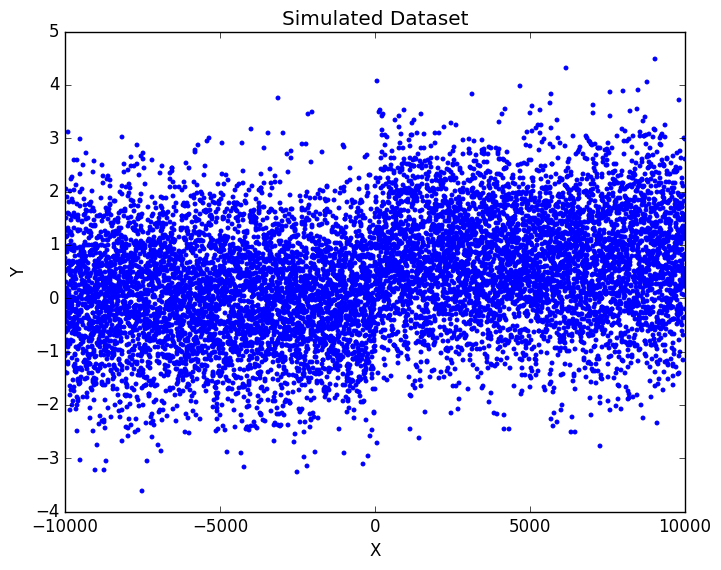

In [3]:
plt.svg(false)
plt.plot(_Xlarge, _Ylarge, ".")
plt.title("Simulated Dataset")
plt.xlabel("X")
plt.ylabel("Y")
;

Now here's some code to obtain the posterior on $\tau$. I take the covariance parameters $\sigma_f^2$, $\sigma_y^2$ and $L$ as known here. This makes the computations much easier, and they can be estimated exactly given enough samples of the Gaussian process anyway.

In [4]:
function g_VarY{T<:Number, S<:Number}(X::Vector{T}, XXt::Symmetric{T}, thresh::T, στ2::T, σβ2::T, σy2::S, σf2::S, L::S)
    n = length(X)
    kern = SE(log(L), log(√σf2))
    In=eye(XXt)
    region = X.>thresh
    II = region * region'
    K = kernel(kern, X)
    VarY = K + στ2*II + σβ2*XXt + (σy2+1e-5)*In
    return VarY
end
function τ_posterior{T<:Real, S<:Number}(X::Vector{Float64}, Y::Vector{Float64}, στ2::T, σβ2::T, σy2::S, σf2::S, L::S, thresh::Float64)
    XXt = Symmetric(X * X')
    VarY = PDMats.PDMat(g_VarY(X, XXt, thresh, στ2, σβ2, σy2, σf2, L))
    region = (X.>thresh)*1.0
    II = region * region' # we're doing this twice. expensive?
    alpha = VarY \ Y
    Eτ_Y =(στ2 * region' * alpha)[1]
    Lck = PDMats.whiten(VarY, region'')
    Vτ_Y = (στ2 - στ2^2 .* Lck' * Lck)[1]
    τ_Y = Normal(Eτ_Y, √(Vτ_Y))
    return τ_Y
end

τ_posterior (generic function with 1 method)

We now obtain this posterior using only the $n$ datapoints nearest to the discontinuity, for $n=1,5,10,50,100,200,300,500,700,1000,2000,5000$. What we want is for the variance of the posterior to initially decline, but then stabilize as we add information that is very far away from the discontinuity.

In [5]:
ithresh = searchsortedfirst(_Xlarge, _thresh)

npoints = [1,5,10,50,100,200,300,500,700,1000,2000,5000]
_τ_posteriors = Array(Normal, length(npoints))
for (i,n) in enumerate(npoints)
    _Xsub = _Xlarge[ithresh-n:ithresh+n]
    _Ysub = _Ylarge[ithresh-n:ithresh+n]
    τpost = τ_posterior(collect(_Xsub), _Ysub, 
        _στ2, 0.0, _σy2_star, _σf2_star, _Lstar, _thresh)
    _τ_posteriors[i] = τpost
end

In [6]:
_τ_postmeans = [mean(τpost) for τpost in _τ_posteriors]
_τ_postvars = [var(τpost) for τpost in _τ_posteriors]
;

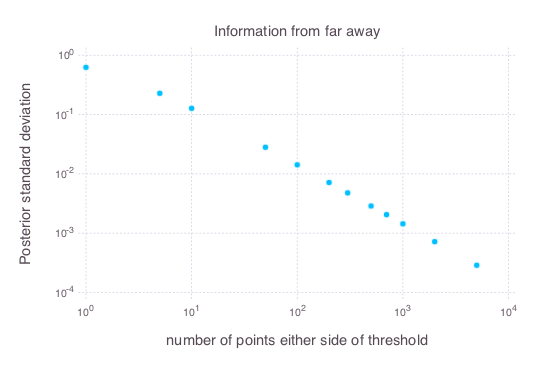

In [7]:
plot(x=npoints, y=_τ_postvars,
    Scale.y_log10,
    Scale.x_log10,
    Geom.point,
    Guide.xlabel("number of points either side of threshold"), 
    Guide.ylabel("Posterior standard deviation"), 
    Guide.title("Information from far away"),
)

Instead, what we see is that the variance continuisly declines as $n^{-1}$. It doesn't matter how far away we measure the process, we always get more information about $\tau$.

Where is this information coming from? Quite simply, the Gaussian Process with squared exponential kernel is expected to revert to its prior mean 0. Therefore, over long distances, a lot of information about $\tau$ can be obtained from the difference in mean on either side of the discontinuity.

In [8]:
mean(_Ylarge[_Xlarge.>_thresh])-mean(_Ylarge[_Xlarge.<_thresh])

0.7429161248583106

This is close to the true $\tau=0.75$.